Ready: 2023-04-01 08:26:00


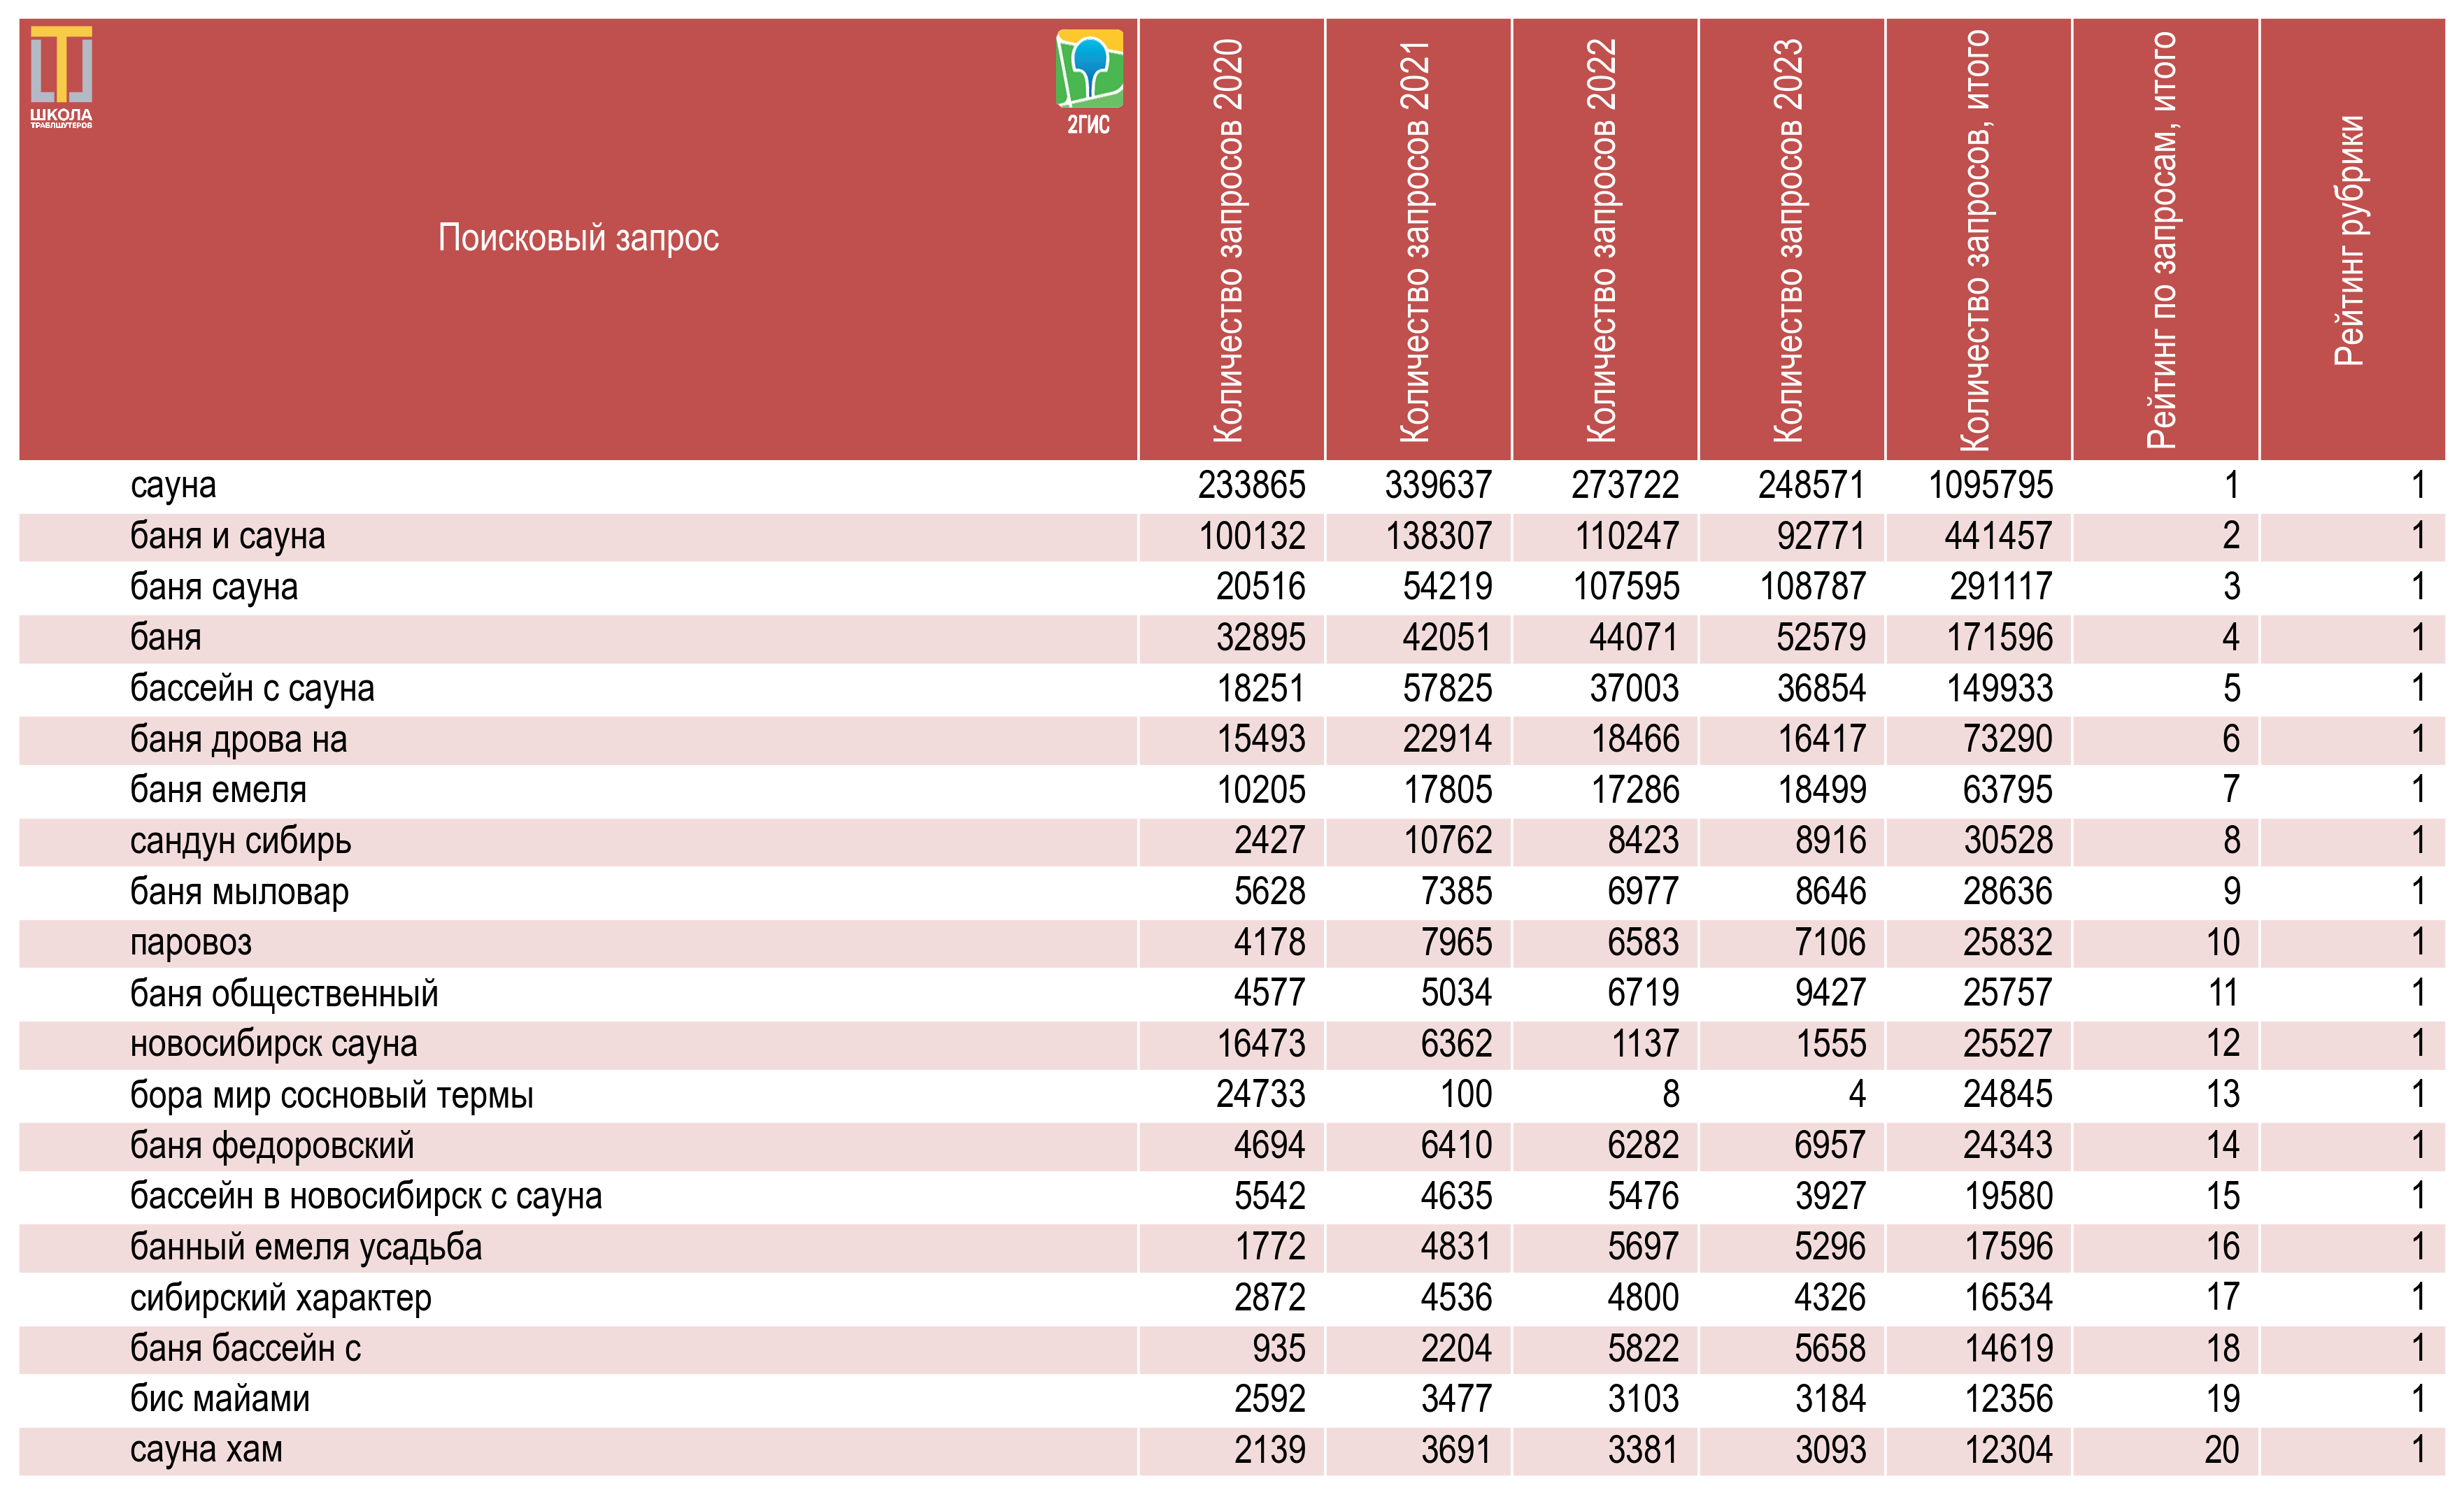

In [107]:
%run 2gis_functions.ipynb

data=pd.read_excel('files/requests_text_novosib.xlsx')

render_mpl_table(data[data['Рейтинг рубрики'] == 1].drop('Рубрика', axis=1).iloc[:20], 'Таблица с лого белый шрифт')

In [113]:
def make_sep(number_str):
    return '{0:,}'.format(number_str).replace(',', ' ')


def render_mpl_table(data, file_name='test', col_width=1.0, row_height=0.625, font_size=16,
                     header_color='#C0504D', row_colors=['#F2DCDB', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array([17.5, 10.8]))
        fig, ax = plt.subplots(figsize=size, dpi=2**8)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, colLoc='center', loc='bottom')

    mpl_table.auto_set_font_size(False)
    cells_dict = dict(six.iteritems(mpl_table._cells))
    
    im = plt.imread(r"C:\Users\Mamed\YandexDisk\_Documents\Проекты\2ГИС 2023\Лого_2ГИС_3.png")
    ax.figure.figimage(im, 1510, 1945, zorder=1)

    im = plt.imread(r"C:\Users\Mamed\YandexDisk\_Documents\Проекты\2ГИС 2023\ШТ лого без фона для таблиц.png")
    ax.figure.figimage(im, 40, 1950, zorder=1)
    
    fpath = Path(mpl.get_data_path(), r"C:\Users\Mamed\Downloads\arialnarrow.ttf")
    
    for k in sorted(cells_dict.keys()):
        cell = cells_dict[k]
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            rotation='vertical' if k != (0,0) else 'horizontal'
            #cell.set_text_props(ma='left')
            cell.set_text_props(color='w', rotation=rotation, ha='center')
            cell.set_facecolor(header_color)
            cell.set_height(0.07)
        else:
            ha = 'right' if k[1] !=0 else 'left'
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
            cell.set_height(0.008)
            cell.set_text_props(wrap=True, ha=ha)
        if k[1]!=0:
            cell.set_width(0.001)
        else:
            cell.set_width(0.006)
        cell.set_text_props(font=fpath)
        cell.set_text_props(fontsize=font_size)
        #ax.axhline(linewidth=1, color='r')
    fig.savefig(f'{file_name}', bbox_inches='tight')
    
def add_image(docx_name, image_name):
    word = 'Восторг и презрение масс захватили рюмочные, купальники, аренда коттеджей и гостевых домов, быстрое питание, паркинги, точки продаж безалкогольных напитков и стендап-клубы. Сюда же попали кафе-кондитерские, рестораны и системы нагревания табака glo:'
    doc = docx.Document(docx_name)
    doc.add_paragraph(word)
    image_to_add = doc.add_picture(image_name)
    image_to_add.width = Cm(17.5)
    image_to_add.height = Cm(10.8)
    doc.save(docx_name)

def make_images(file_name, header_color, row_color):
    df = pd.read_excel(file_name)

    df.columns = ['Рубрика', 'Поисковый запрос', 'Количество\nзапросов 2020',
           'Количество\nзапросов 2021', 'Количество\nзапросов 2022',
           'Количество\nзапросов 2023', 'Количество\nзапросов, итого',
           'Рейтинг\nпо запросам, итого', 'Рейтинг рубрики']

    for i in df.columns[2:-2]:
        df[i] = df[i].apply(make_sep)

    for i in df['Рейтинг рубрики'].unique()[1:]:
        dfx = df[df['Рейтинг рубрики'] == i].drop('Рубрика', axis=1).iloc[:20]
        col_postfix = df[df['Рейтинг рубрики'] == i]['Рубрика'].iloc[0]
        col_name = f'Поисковые запросы по рубрике\n«{col_postfix}»'
        dfx = dfx.rename({'Поисковый запрос':col_name}, axis=1).drop(['Рейтинг рубрики', 'Рейтинг\nпо запросам, итого'], axis=1)
        render_mpl_table(dfx, f'{file_name[-6]}pictures/img_{i}.png', font_size=16, header_color=header_color, row_colors=[row_color, 'w'])
        add_image('report.docx', f'{file_name[-6]}pictures/img_{i}.png')

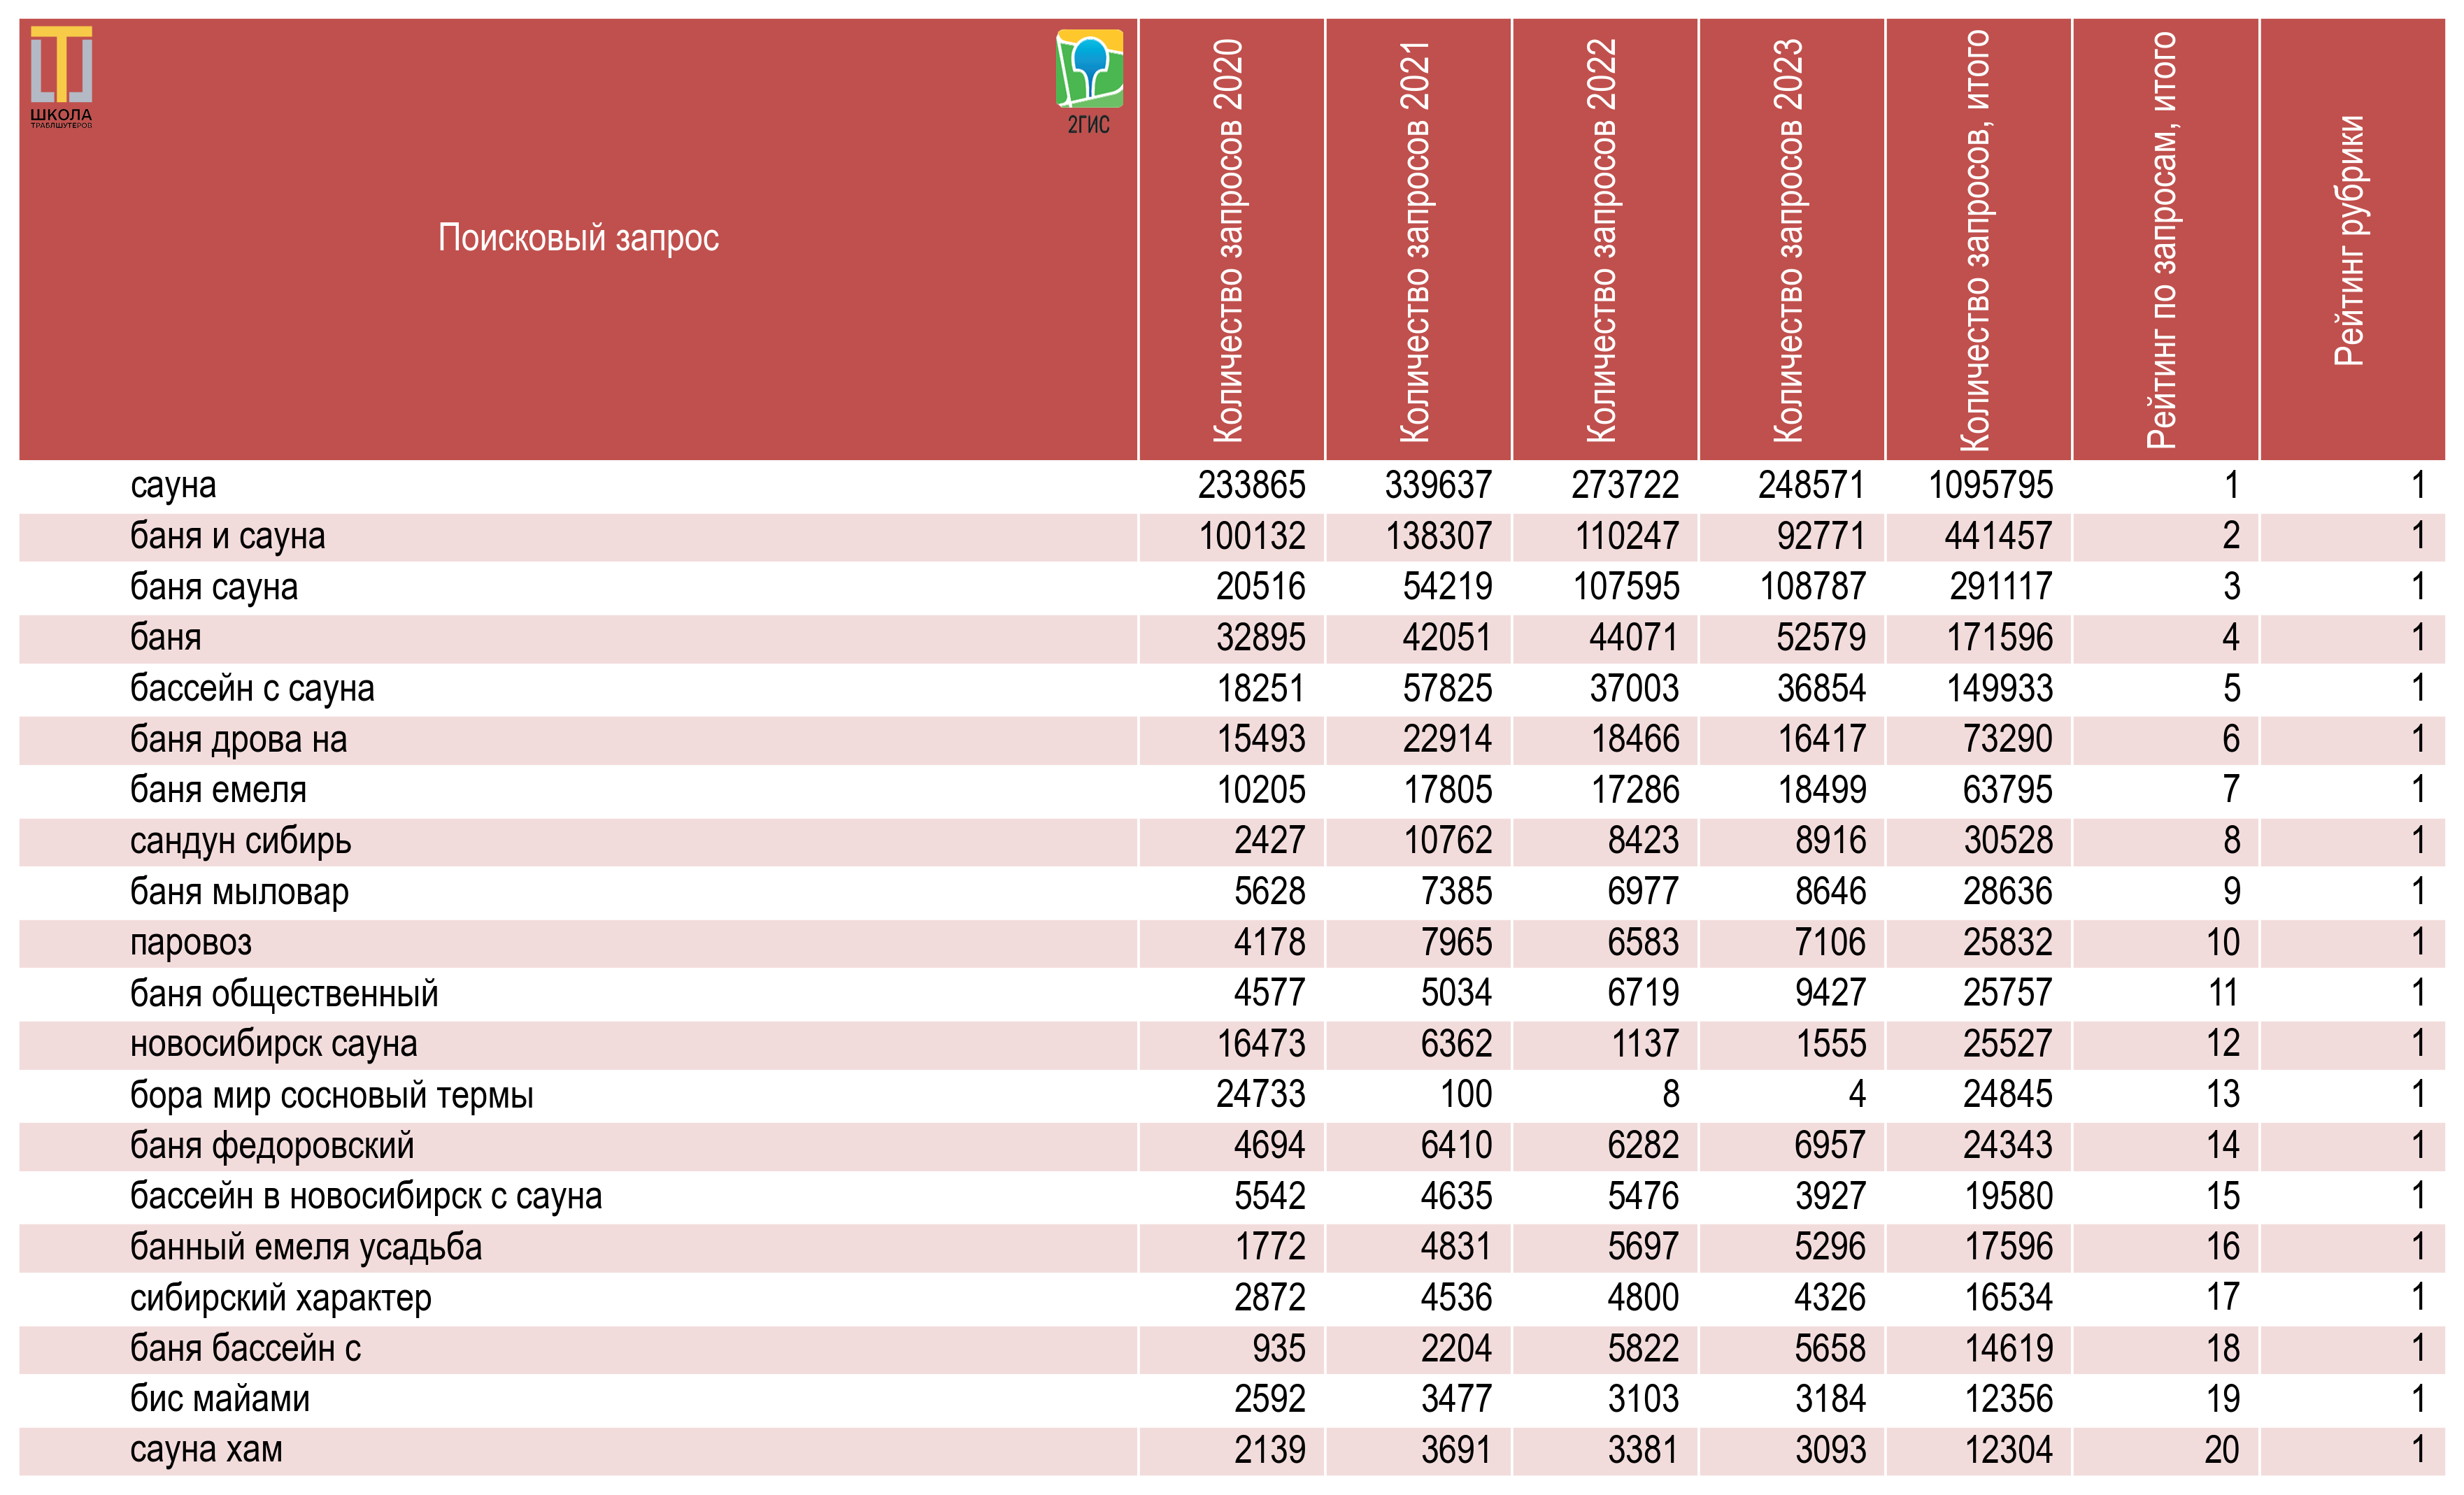

In [114]:
render_mpl_table(data[data['Рейтинг рубрики'] == 1].drop('Рубрика', axis=1).iloc[:20], 'Таблица с лого черный шрифт')